## CNN

VAE를 통해 차원을 축소한 데이터 사용

In [162]:
import pandas as pd
import numpy as np
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, initializers
from keras.optimizers import RMSprop, Adadelta, Adam, SGD, Adagrad
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
import pickle # 파이썬 객체저장을 위한 모듈

## 사전값 셋팅 확인 필수

In [250]:
df = 'core'   # 수정필수
# core/all/main




# core설정시 확인해야 함
# R을 통해 확인한 stepwise 유의 변수 리스트
core_factors = ['DR00000136','6000201001O0','6000903016D1','FNMKFN02','6000901002D1','S41000210FD1',
'6000207003O0','DR00000052','6000906001D6','DR00000156','6000901001D3','DR00000082',
'S41000210FD2','6000902001D2','6000908001D3','6000904001D3','6000908001D2','S41B0D1009O0',
'6000901002D3','6000903001D2','6000403001O0','CO10100170O0','DR00000113','6000908001D7']

#  키별로 비율 배분이 잘 됐는지 확인
if df == 'all':
    max_idx = 707
else:
    max_idx = 124
    

In [251]:
if df == 'all':
    file_nm = "./pickles/vae_all.p"
elif df == 'main':
    file_nm = "./pickles/vae_main.p"
elif df == 'core':
    file_nm = "./pickles/vae_core.p"

#파이썬 객체 읽어오기
with open(file_nm, 'rb') as file:  
    z_train = pickle.load(file)
    z_test = pickle.load(file)
    y_train = pickle.load(file)
    y_test = pickle.load(file)
    train_set = pickle.load(file)
    test_set = pickle.load(file)   
    

In [252]:
df, z_train.shape, z_test.shape, y_train.shape, y_test.shape

('core', (755, 10), (333, 10), (755,), (333,))

### 모델 입력값 설정

In [253]:
np.random.seed(42)

# 분류갯수
classes = 2

# 학습데이터
img_rows = 1
img_cols = z_train.shape[1] 



In [254]:
img_rows, img_cols

(1, 10)

### input shape 변경

In [255]:
# X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
# X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_train = z_train.reshape(z_train.shape[0], 1, z_train.shape[1], 1) # (1, # of features, # of chnnels) # input.shape[1:끝]
X_test = z_test.reshape(z_test.shape[0], 1, z_test.shape[1], 1) # (1, # of features, # of chnnels) # input.shape[1:끝]

# 변수명 전환
Y_train = y_train
Y_test = y_test

input_shape= X_train.shape[1:4]
print(input_shape)

(1, 10, 1)


In [256]:
z_train.shape[1]

10

In [257]:
if z_train.shape[1] >= 100:
    filter_size = 32    
    MaxPool_size  = 4
elif z_train.shape[1] >= 50:
    filter_size = 8    
    MaxPool_size = 4
else:
    filter_size = input_shape[1]/2    
    MaxPool_size = 2 


In [258]:
# Y값을 1개항목에서 카테고리화 함
Y_train = to_categorical(y_train, num_classes=classes) # one-hot 인코딩
Y_test = to_categorical(y_test, num_classes=classes) # one-hot 인코딩

Y_train.shape, Y_test.shape

((755, 2), (333, 2))

## CNN 모델 설계

In [259]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((755, 1, 10, 1), (333, 1, 10, 1), (755, 2), (333, 2))

In [260]:
filter_size = 4


In [261]:


# 1. 모델구성
model = Sequential()

model.add(Conv2D(filter_size, (1, 2), input_shape = X_train.shape[1:4], activation = 'elu', padding='same')) # 2D (1, 4) size 필터
model.add(Activation('relu'))

model.add(Conv2D(filter_size, (1, 2), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((1, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filter_size, (1, 2), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(filter_size, (1, 2)))
model.add(Activation('relu'))
model.add(MaxPooling2D((1, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(classes, activation = 'softmax'))# 마지막 class 분류

# 2. 모델 학습과정 설정하기
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


# 3. 모델 학습시키기
hist = model.fit(X_train, Y_train, batch_size = 500, epochs = 100, verbose = 1, validation_split = .2)



Train on 604 samples, validate on 151 samples
Epoch 1/100
604/604 [==============================] - 7s 11ms/step - loss: 0.6695 - acc: 0.7301 - val_loss: 0.7443 - val_acc: 0.0000e+00
Epoch 2/100
604/604 [==============================] - 0s 83us/step - loss: 0.6665 - acc: 0.7500 - val_loss: 0.7506 - val_acc: 0.0000e+00
Epoch 3/100
604/604 [==============================] - 0s 68us/step - loss: 0.6593 - acc: 0.7434 - val_loss: 0.7573 - val_acc: 0.0000e+00
Epoch 4/100
604/604 [==============================] - 0s 79us/step - loss: 0.6554 - acc: 0.7599 - val_loss: 0.7645 - val_acc: 0.0000e+00
Epoch 5/100
604/604 [==============================] - 0s 78us/step - loss: 0.6560 - acc: 0.7450 - val_loss: 0.7720 - val_acc: 0.0000e+00
Epoch 6/100
604/604 [==============================] - 0s 61us/step - loss: 0.6610 - acc: 0.7434 - val_loss: 0.7792 - val_acc: 0.0000e+00
Epoch 7/100
604/604 [==============================] - 0s 91us/step - loss: 0.6523 - acc: 0.7500 - val_loss: 0.7867 - val_acc:

604/604 [==============================] - 0s 63us/step - loss: 0.5089 - acc: 0.7500 - val_loss: 1.0107 - val_acc: 0.0000e+00
Epoch 60/100
604/604 [==============================] - 0s 107us/step - loss: 0.5048 - acc: 0.7500 - val_loss: 1.0036 - val_acc: 0.0000e+00
Epoch 61/100
604/604 [==============================] - 0s 79us/step - loss: 0.4964 - acc: 0.7500 - val_loss: 0.9976 - val_acc: 0.0000e+00
Epoch 62/100
604/604 [==============================] - 0s 92us/step - loss: 0.4976 - acc: 0.7500 - val_loss: 0.9925 - val_acc: 0.0000e+00
Epoch 63/100
604/604 [==============================] - 0s 92us/step - loss: 0.4953 - acc: 0.7500 - val_loss: 0.9889 - val_acc: 0.0000e+00
Epoch 64/100
604/604 [==============================] - 0s 69us/step - loss: 0.4987 - acc: 0.7500 - val_loss: 0.9846 - val_acc: 0.0000e+00
Epoch 65/100
604/604 [==============================] - 0s 112us/step - loss: 0.5006 - acc: 0.7500 - val_loss: 0.9776 - val_acc: 0.0000e+00
Epoch 66/100
604/604 [================

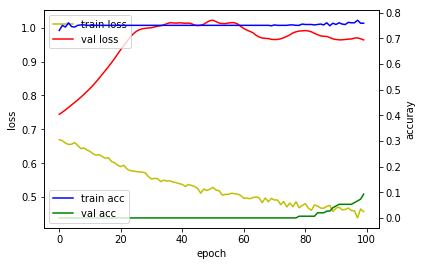

755/755 [==============================] - 0s 123us/step
Train score: 0.5267
Train accuracy: 0.6318
333/333 [==============================] - 0s 210us/step
Test score: 0.5379
Test accuracy: 0.6336


In [262]:

# 4. 학습과정 살펴보기(그래프)
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


# 5. 모델 평가하기 - 테스트셋
'''
score는 비용함수에 대한 평가값
'''

score = model.evaluate(X_train, Y_train, verbose=1)
print('Train score: {:.4f}'.format(score[0]))
print('Train accuracy: {:.4f}'.format(score[1]))


score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score: {:.4f}'.format(score[0]))
print('Test accuracy: {:.4f}'.format(score[1]))

# model.evaluate ; 손실 값을 계산하는 데 사용
# model.predict_classes() ; 범주 출력을 계산하는 데 사용
# model.predict_proba() ; 범주 확률을 계산하는 데 사용


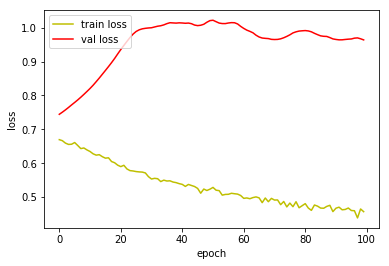

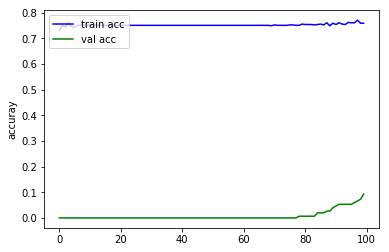

In [263]:

# 5. 분리된 그래프

# loss
fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

# accuray
fig, acc_ax = plt.subplots()

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left')

plt.show()
